In [1]:
# Reading data and plot it.
import pandas as pd
import matplotlib.pyplot as plt

# Stream learning
from river import compose, preprocessing, linear_model, tree, metrics, evaluate, feature_extraction, \
    utils, stats, compat, drift

# Batch learning 
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.preprocessing import StandardScaler as SklearnStandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import seaborn as sns

# Load dataset

In [19]:
# Read api request from a csv
df = pd.read_csv("datasets/data.csv")

# Create the target feature and eliminate redundant features
df = df.drop(["Unnamed: 0", "weather.main", "weather.description", "weather.icon"], axis = 1)
df.head(2)

,dt,main.temp,main.feels_like,main.pressure,main.humidity,main.temp_min,main.temp_max,wind.speed,wind.deg,wind.gust,clouds.all,weather.id,rain.1h
0,1708617600,10.79,9.83,1010,73,9.14,11.61,7.72,290,14.92,75,803,NaN
1,1708621200,9.69,7.35,1010,81,8.58,11.40,4.63,290,NaN,75,803,NaN


# Analisis descriptivo

Numerical features

In [20]:
# Check numerical features and number of nulls
exclude_features = ["dt", "weather.id"]
summary = df.drop(columns=exclude_features).describe().transpose()
summary['null_count'] = df.isnull().sum()

# Drop these two columns because they have too many nulls
df = df.drop(["wind.gust", "rain.1h"], axis = 1)
summary

,count,mean,std,min,25%,50%,75%,max,null_count
main.temp,8105.0,15.223013,4.343804,0.40,12.26,15.26,18.36,30.82,0
main.feels_like,8105.0,14.867462,4.948661,-2.62,11.76,15.08,18.39,34.06,0
main.pressure,8105.0,1016.258606,8.609523,976.00,1012.00,1017.00,1021.00,1038.00,0
main.humidity,8105.0,83.708822,10.288154,0.00,78.00,86.00,91.00,100.00,0
main.temp_min,8105.0,14.090116,4.354793,0.40,11.36,14.32,17.16,29.75,0
main.temp_max,8105.0,16.279006,4.421052,2.47,13.27,16.07,19.40,33.15,0
wind.speed,8105.0,3.732584,2.353262,0.00,2.06,3.13,4.92,18.78,0
wind.deg,8105.0,183.830845,110.814811,0.00,117.00,180.00,280.00,360.00,0
wind.gust,1279.0,8.259398,5.200455,0.45,3.58,7.60,12.35,25.21,6826
clouds.all,8105.0,41.251203,35.334767,0.00,0.00,40.00,75.00,100.00,0


Categorical features

In [21]:
df['weather.id'] = df['weather.id'].astype('category')
summary = df['weather.id'].describe(include=['category']).transpose()
summary

count     8105
unique      16
top        800
freq      2190
Name: weather.id, dtype: int64

# Pipeline

In [35]:
import copy
from river import stream

def create_model(modelo):
    cols_rolling = ["main.feels_like", "main.pressure", "main.humidity", "wind.speed", "wind.deg"]
    to_discard = ['Unnamed: 0', 'wind.gust', 'weather.main', 'weather.description', 'weather.icon', 'rain.1h', 'temp_diff_6h'
                  "year_month"]

    def get_date_features(x):
        x["dt"] = pd.to_datetime(x["dt"], unit = "s")
        month =  x['dt'].month
        return {'month': month}

    model = get_date_features
    model |= compose.Discard(*to_discard)
    for col in cols_rolling:
        model += feature_extraction.Agg(on = col, by=None, how=utils.Rolling(stats.Mean(), 3))

    model |= preprocessing.StandardScaler()
    model |= modelo

    return model

def stream_learning(X, y, X_test, y_test, modelo, drift_detect):
    # Almacenamos los accuracies y los indices donde hay cambios.
    drifts = []
    acc_values = []

    # Inicializamos modelo, detector de drift y metricas
    drift_detector = drift_detect
    model = copy.deepcopy(modelo)
    r2 = metrics.R2()

    counter = 0
    for xi, yi in stream.iter_pandas(X, y):

        if drift_detector.drift_detected:
            print(f'Change detected at index {counter}')
            # Guardar el indice donde se detecta un cambio.
            drifts.append(counter)
            # Reiniciar el modelo cuando se detecta un cambio
            model = copy.deepcopy(modelo)
        counter += 1
        y_pred = model.predict_one(xi)
        model.learn_one(xi, yi)

        if y_pred != None:
            #Actualizamos el drift detector
            drift_detector.update(yi)
        

    for xi, yi in stream.iter_pandas(X_test, y_test):
        if drift_detector.drift_detected:
            print(f'Change detected at index {counter}')
            print(r2.get())
            # Guardar el indice donde se detecta un cambio.
            drifts.append(counter)
            # Reiniciar el modelo cuando se detecta un cambio
            model = copy.deepcopy(modelo)

        y_pred = model.predict_one(xi)
        model.learn_one(xi, yi)
        
        if y_pred != None:
            r2.update(yi, y_pred)
            #Actualizamos el drift detector
            drift_detector.update(yi)

        if counter % 100 == 0 and counter!=0:
            acc_values.append(r2.get())
        counter += 1

    return acc_values, drifts

# Train-test partition

In [30]:
test_df = df.tail(1000)
train_df = df.iloc[:-1000]

X_train = train_df
y_train = X_train.pop('main.temp')
X_test = test_df
y_test = X_test.pop('main.temp')

# Stream learning results

In [38]:
def get_models_results(X_train, y_train, X_test, y_test, models, drift_detector):
    accuracies = []
    drifts = []
    reports = []

    for model in models:
        model_instance = create_model(model)
        accuracies_model, drifts_model = stream_learning(X_train, y_train, X_test, y_test,
                                                        modelo=model_instance, drift_detect=drift_detector)
        
        accuracies.append(accuracies_model)
        drifts.append(drifts_model)

    # Optionally, you can zip the results and print them together
    for i, model in enumerate(models):
        print(f"Results for {model.__class__.__name__}:")
        print("Accuracies:", accuracies[i])
        print("Drifts:", drifts[i])
        print("\n")

    return accuracies, drifts, reports

# Muestra el resultado de dos modelos, hay que adaptarla para que saque 3.
def plot_r2_dual(acc_list, drifts, colors, labels, title):
    """
    Plots the accuracy of the model with a detector, visualizing the points with 
    a concept drift.

    Parámetros:
    - acc_list: Lista con los valores de precisión para cada modelo incremental con detector.
    - drifts: Lista con los indices donde se produjeron cambios de la distribución para cada modelo.
    """

    for i, acc_values in enumerate(acc_list):
        color = colors[i]
        label = labels[i]
        indices = np.arange(len(acc_values))
        indices = indices*100
        plt.plot(indices, acc_values, label=label, color=color, marker='o')

    for i, drift in enumerate(drifts):
        color = colors[i]
        label = labels[i]
        for value in drift:
            plt.axvline(x=value, color=color, linestyle='--', label=label[i])

    plt.legend()
    plt.xlabel('Test data proccessed')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.show()

# Obtain results.
models = [linear_model.LinearRegression(),
          tree.HoeffdingTreeRegressor(grace_period=10),
          tree.HoeffdingTreeRegressor(grace_period=25),
          tree.HoeffdingTreeRegressor(grace_period=50),
          linear_model.Perceptron()]

# Plot results
colors = ["blue", "red", "orange", "yellow", "green"]
labels = ["LogisticRegression", "HoeffdingTree10", "HoeffdingTree25", "HoeffdingTree50", "Perceptron"]
acc, drifts, reports = get_models_results(X_train, y_train, X_test, y_test, models, drift_detector= drift.ADWIN(delta=0.3))
plot_r2_dual(acc, drifts, colors, labels, title = "Accuracy over time with ADWIN")

Change detected at index 64
Change detected at index 96
Change detected at index 160
Change detected at index 192
Change detected at index 224
Change detected at index 256
Change detected at index 320
Change detected at index 352
Change detected at index 416
Change detected at index 512
Change detected at index 576
Change detected at index 640
Change detected at index 672
Change detected at index 736
Change detected at index 768
Change detected at index 832
Change detected at index 928
Change detected at index 992
Change detected at index 1056
Change detected at index 1120
Change detected at index 1184
Change detected at index 1248
Change detected at index 1312
Change detected at index 1376
Change detected at index 1472
Change detected at index 1504
Change detected at index 1536
Change detected at index 1600
Change detected at index 1664
Change detected at index 1696
Change detected at index 1728
Change detected at index 1824
Change detected at index 1856
Change detected at index 1888


KeyboardInterrupt: 

Results for LogisticRegression:
Accuracies: [0.6237623762376238, 0.582089552238806, 0.6146179401993356, 0.6433915211970075, 0.6227544910179641, 0.6056572379367721, 0.6248216833095578, 0.6279650436953808, 0.6204217536071032]
Drifts: []
Report:            Precision   Recall   F1       Support  
                                                  
       0      64.88%   71.51%   68.03%       558  
       1      58.70%   51.13%   54.66%       442  
                                                  
   Macro      61.79%   61.32%   61.34%            
   Micro      62.50%   62.50%   62.50%            
Weighted      62.15%   62.50%   62.12%            

                 62.50% accuracy                  


Results for HoeffdingTreeClassifier:
Accuracies: [0.6237623762376238, 0.5870646766169154, 0.6079734219269103, 0.6334164588528678, 0.6227544910179641, 0.6073211314475874, 0.5920114122681883, 0.5967540574282147, 0.5904550499445061]
Drifts: []
Report:            Precision   Recall   F1       Suppo

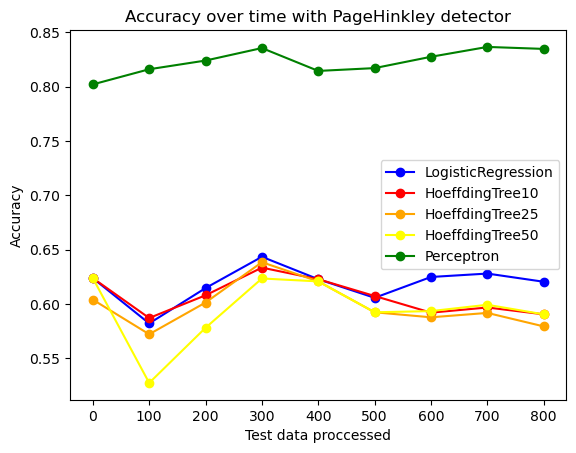

In [56]:
acc, drifts, reports = get_models_results(X_train, y_train, X_test, y_test, models, drift_detector= drift.PageHinkley)
plot_accuracy_dual(acc, drifts, colors, labels, title = "Accuracy over time with PageHinkley detector")

# Batch learning results

In [69]:
X_train.columns

Index(['dt', 'main.temp', 'main.feels_like', 'main.pressure', 'main.humidity',
       'main.temp_min', 'main.temp_max', 'wind.speed', 'wind.deg',
       'clouds.all', 'weather.id', 'year_month'],
      dtype='object')

In [74]:
def create_model(modelo):

    # model = compose.Pipeline(
    # # ('features', compose.TransformerUnion(
    # #     ('last_14_mean', feature_extraction.Agg(on = "main.temp", by=None, how=utils.Rolling(stats.Mean(), 3))),
    # #     ('last_14_mean', feature_extraction.Agg(on = "main.feels_like", by=None, how=utils.Rolling(stats.Mean(), 3))),
    # #     ('last_14_mean', feature_extraction.Agg(on = "main.pressure", by=None, how=utils.Rolling(stats.Mean(), 3))),
    # #     ('last_14_mean', feature_extraction.Agg(on = "main.humidity", by=None, how=utils.Rolling(stats.Mean(), 3))),
    # #     ('last_14_mean', feature_extraction.Agg(on = "wind.speed", by=None, how=utils.Rolling(stats.Mean(), 3))),
    # #     ('last_14_mean', feature_extraction.Agg(on = "wind.deg", by=None, how=utils.Rolling(stats.Mean(), 3))),
    # # )),
    # ('drop_non_features', compose.Discard('wind.gust', 'weather.main', 'weather.description','weather.icon')),
    # ('scale', preprocessing.StandardScaler()),
    # ('lin_reg', modelo)
    # )

    model = compose.Pipeline(
        ('scale', preprocessing.StandardScaler()),
        ('ml_model', linear_model.LogisticRegression())
    )

    return model

river_model = linear_model.LogisticRegression()
river_pipeline = create_model(river_model)

sk_pipeline = compat.convert_river_to_sklearn(river_pipeline)
print(sk_pipeline)
sk_pipeline.fit(X_train.drop(["dt", "weather.id", "year_month"], axis = 1),y_train)

Pipeline(steps=[('scale',
                 River2SKLTransformer(river_estimator=StandardScaler (
  with_std=True
))),
                ('ml_model',
                 River2SKLClassifier(river_estimator=LogisticRegression (
  optimizer=SGD (
    lr=Constant (
      learning_rate=0.01
    )
  )
  loss=Log (
    weight_pos=1.
    weight_neg=1.
  )
  l2=0.
  l1=0.
  intercept_init=0.
  intercept_lr=Constant (
    learning_rate=0.01
  )
  clip_gradient=1e+12
  initializer=Zeros ()
)))])


c:\Users\Alogon\anaconda3\envs\ML2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [73]:
X_train.head()

,dt,main.temp,main.feels_like,main.pressure,main.humidity,main.temp_min,main.temp_max,wind.speed,wind.deg,clouds.all,weather.id,year_month
0,1708617600,10.79,9.83,1010,73,9.14,11.61,7.72,290,75,803,2024-02
1,1708621200,9.69,7.35,1010,81,8.58,11.40,4.63,290,75,803,2024-02
2,1708624800,9.04,6.77,1010,84,8.03,10.44,4.12,260,75,803,2024-02
3,1708628400,8.74,6.66,1010,82,7.50,10.50,3.60,250,75,300,2024-02
4,1708632000,8.17,5.24,1010,84,6.92,9.38,5.14,250,75,300,2024-02


In [67]:
from river import compose
model = compose.Pipeline(
    ('scale', preprocessing.StandardScaler()),
    ('ml_model', linear_model.LogisticRegression())
)

# This funtion returns an object of type SKLRegressorWrapper 
# which is compatible with the signature of sklearn
model = compat.convert_river_to_sklearn(model)